# Modeling:

Amin Khoeini

---

As we see in the last step, Random Forest Regressor with the Hyperparameters that the GrideSearch pick, is the model with best R2 score and least mean absolute error.
With the R2 of 0.63 and mae of 40 million dollar for the box-office, we can already assume that this model won't be able to get a perfect prediction of the box-office.
Here I try to make the same model, train i ton train set, then use the test set to see the performance of the model for the diffrent class of film.

In [1]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV,cross_val_score
from sklearn.linear_model import LinearRegression,Lasso,ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,explained_variance_score


In [2]:
# Read the process csv file from EDA
movie_score = pd.read_csv('/Users/Amin/Documents/GitHub/Movie_boxoffice_reviews/data/processed/pre_process_movie.csv')

In [3]:
#Save the class of the movies as movie_class then drop it from the data

movie_class = movie_score['class']
movie_score.drop(columns='class',inplace=True)

In [4]:
#split the data to train/test set. 70% train and 30% test.
X_train, X_test, y_train, y_test = train_test_split(movie_score.drop(columns='All_time_gross'), 
                                                    movie_score.All_time_gross, test_size=0.2, 
                                                    random_state=47)

In [5]:
#check the train and test data shape

X_train.shape,y_train.shape

((2620, 18), (2620,))

In [6]:
X_test.shape,y_test.shape

((656, 18), (656,))

In [7]:
#Making the Random Forest Regressor model with the same HyperParameters from Pre-Process GridSearch
rf_model = RandomForestRegressor(max_depth=60,n_estimators=50,
                                 min_samples_leaf= 2,min_samples_split= 6,random_state=47)

In [8]:
rf_model.fit(X_train,y_train)

RandomForestRegressor(max_depth=60, min_samples_leaf=2, min_samples_split=6,
                      n_estimators=50, random_state=47)

In [9]:
cv_results = cross_validate(rf_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [10]:
np.mean(cv_results['test_score'])

-40822549.687326

Now let's get the prediction for the test set and see the model performance.

In [11]:
#get the prediction for the test set
y_pred = rf_model.predict(X_test)

In [12]:
mean_absolute_error(y_test,y_pred)

54962296.970882215

In [13]:
explained_variance_score(y_test,y_pred)

0.6105810264206532

The mean absolute error for the test set is much higher.

Let's create some metrics for each perdiction and analyze the perdiction for each class.

In [14]:
# make a result df and create some metrics for the predictions.

result = pd.DataFrame(y_test.values,y_pred).reset_index() 
result = pd.concat([result,movie_class],axis=1).dropna()
result

,index,0,class
0,4.946669e+06,1473445.0,Average
1,1.360670e+08,47275717.0,Average
2,5.355489e+06,7078.0,Average
3,1.999655e+07,4552970.0,Indie
4,1.997942e+07,13313581.0,Blockbuster
...,...,...,...
651,7.887841e+05,155215.0,Indie
652,8.440713e+05,507914.0,Average
653,5.099886e+05,61465.0,Indie
654,9.560158e+07,112983889.0,Indie


In [15]:
result = result.rename(columns={'index':'box-office',0:'prediction'})
result['absolute_error'] = np.abs(result['prediction'] - result['box-office'])
result['acuracy_of_perdiction'] =100 - ((result['absolute_error']/result['box-office']*100))
result['prediction_error'] = (np.abs((result['box-office']-result['prediction']))/result['box-office']) * 100

In [16]:
result.head()

,box-office,prediction,class,absolute_error,acuracy_of_perdiction,prediction_error
0,4.946669e+06,1473445.0,Average,3.473224e+06,29.786608,70.213392
1,1.360670e+08,47275717.0,Average,8.879130e+07,34.744434,65.255566
2,5.355489e+06,7078.0,Average,5.348411e+06,0.132163,99.867837
3,1.999655e+07,4552970.0,Indie,1.544358e+07,22.768774,77.231226
4,1.997942e+07,13313581.0,Blockbuster,6.665839e+06,66.636475,33.363525


In [17]:
result.acuracy_of_perdiction.describe()

count       656.000000
mean       -267.121505
std        6823.041557
min     -174584.328616
25%           2.625052
50%          22.266784
75%          58.885457
max          99.922214
Name: acuracy_of_perdiction, dtype: float64

In [18]:
result.acuracy_of_perdiction[result.acuracy_of_perdiction<0]

5       -32.756295
9      -325.964230
10      -76.342430
13     -604.923508
54     -284.130433
          ...     
622    -194.434409
633    -323.876210
636    -125.897783
639     -10.511615
643   -1843.008060
Name: acuracy_of_perdiction, Length: 69, dtype: float64

As we can see, sometime the error of prediction is more than the box-office itself ( specially for the Blockbuster) and that wil cause the acuracy be a negative percentage.
We can set that to zero and assume in that cases acuracy percnetage is zero.

In [19]:
result.loc[result.acuracy_of_perdiction<0,'acuracy_of_perdiction'] = 0

In [20]:
result.head(10)

,box-office,prediction,class,absolute_error,acuracy_of_perdiction,prediction_error
0,4.946669e+06,1473445.0,Average,3.473224e+06,29.786608,70.213392
1,1.360670e+08,47275717.0,Average,8.879130e+07,34.744434,65.255566
2,5.355489e+06,7078.0,Average,5.348411e+06,0.132163,99.867837
3,1.999655e+07,4552970.0,Indie,1.544358e+07,22.768774,77.231226
4,1.997942e+07,13313581.0,Blockbuster,6.665839e+06,66.636475,33.363525
5,1.033331e+06,2405143.0,Average,1.371812e+06,0.000000,132.756295
6,4.454658e+06,428752.0,Indie,4.025906e+06,9.624803,90.375197
7,1.200517e+08,94019120.0,Average,2.603257e+07,78.315532,21.684468
8,7.531574e+07,246985.0,Blockbuster,7.506876e+07,0.327933,99.672067
9,1.720607e+07,90497778.0,Indie,7.329171e+07,0.000000,425.964230


In [21]:
result_indie = result[result['class'] == 'Indie']
result_indie.acuracy_of_perdiction.describe()

count    410.000000
mean      34.465736
std       32.420447
min        0.000000
25%        4.227960
50%       22.637489
75%       62.414103
max       99.868207
Name: acuracy_of_perdiction, dtype: float64

In [22]:
result_average = result[result['class'] == 'Average']
result_average.acuracy_of_perdiction.describe()

count    213.000000
mean      30.515639
std       30.797743
min        0.000000
25%        1.722231
50%       22.639659
75%       54.993180
max       99.922214
Name: acuracy_of_perdiction, dtype: float64

In [23]:
result_blockbuster = result[result['class'] == 'Blockbuster']
result_blockbuster.acuracy_of_perdiction.describe()

count    33.000000
mean     22.730181
std      26.791237
min       0.000000
25%       0.327933
50%      12.502487
75%      38.616870
max      89.489173
Name: acuracy_of_perdiction, dtype: float64

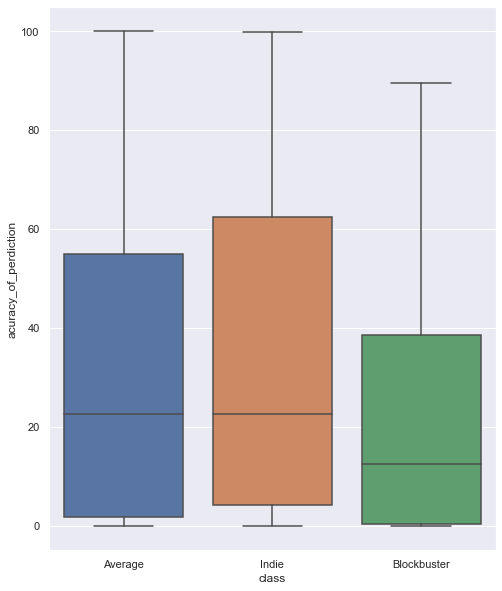

In [24]:
sns.set(rc={'figure.figsize':(8,10)})
_ = sns.boxplot(y='acuracy_of_perdiction',data=result,x='class')

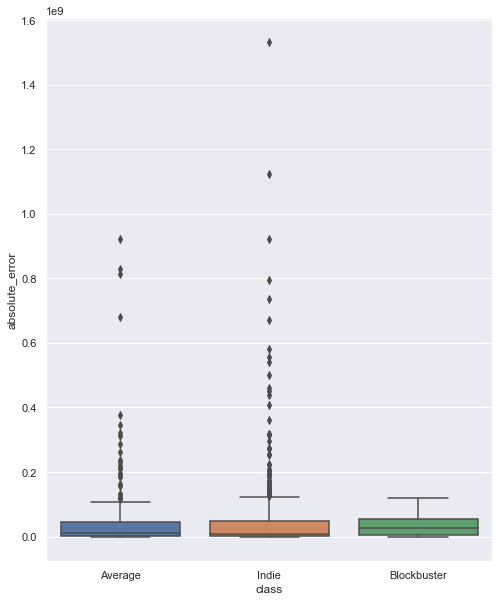

In [25]:
sns.set(rc={'figure.figsize':(8,10)})
_ = sns.boxplot(y='absolute_error',data=result,x='class')

We can see the acuracy for the Blockbuster is worse among the clases and that is mainly because box-office for those film has a very high number, and even if the prediction is in close range of the real value the diffrence still be a high number and that would cause the acuracy percentage drop.
beside that we see what we expect from the R2 score. Acuracy arond 20 to 60 percent with the median around 30 depands on the class.
While the model won't be able to get us a perfect prediction, but we can assume it will classify the film class with high acuracy. 
We can examine that with some real vote data that are more recent and are not in our original dataset.

The absoulate error on the other hand is around 50 to 10 millions for the most cases, which is a good number for the Blockbuster and Average class. Althought there are some outlier in Indie and average class with very high error.



## Spider-Man : No Way Home (2021)
---

let's start with a big movie in 2021. __Spider-Man : No Way Home.__

In [26]:
spider = pd.DataFrame({     'tom_cri_vote':[93],
                            'tom_cri_num':[385],
                            'tom_aud_vote':[98],
                            'tom_aud_num':[25000],
                            'met_cri_vote':[71],
                            'met_cri_num':[59],
                            'met_aud_vote':[89],
                            'met_aud_num':[2013],
                            'imdb_vote':[87],
                            'imdb_num':[451025],
                            'imdb_us_vote':[87],
                            'imdb_us_num':[34371],
                            'imdb_nus_vote':[84],
                            'imdb_nus_num':[87342],
                            'imdb_fem_vote':[88],
                            'imdb_fem_num':[26676],
                            'imdb_mal_vote':[86],
                            'imdb_mal_num':[162657]
                 })

In [27]:
spider_box_predict = rf_model.predict(spider.iloc[0].array.reshape(1, -1))

In [28]:
spider_box_predict

array([8.58447524e+08])

The model predict that this film box-office will be 850 million dollars based on the vote data that we provide.
The film end up with 1.7 Bilion dollar in box-office. There is a very large error in the model prediction ( around 900 million dollar) but the model succesfuly predict that this film going to be a big Blockbuster with very high box-office gross.

__Spider-Man : No Way Home__

__Real Box-office : 1.7 Billion Dollars__


__Perdicted box office : 850 Million Dollars__




## Dune (2021):
---

Let's check another promising film in 2021: __Dune__. althoght it is not a Super Hero or a Marvel movie, but with very well-known casts, huge advertisment campain and pick the chrismas time relese, the producer hope to gain a good gross in box-office, number close to a billion.

In [29]:
dune = pd.DataFrame({      'tom_cri_vote':[83],
                            'tom_cri_num':[456],
                            'tom_aud_vote':[90],
                            'tom_aud_num':[5000],
                            'met_cri_vote':[74],
                            'met_cri_num':[67],
                            'met_aud_vote':[80],
                            'met_aud_num':[1371],
                            'imdb_vote':[81],
                            'imdb_num':[478505],
                            'imdb_us_vote':[81],
                            'imdb_us_num':[44798],
                            'imdb_nus_vote':[80],
                            'imdb_nus_num':[142364],
                            'imdb_fem_vote':[81],
                            'imdb_fem_num':[39777],
                            'imdb_mal_vote':[81],
                            'imdb_mal_num':[224114]
                 })

In [30]:
dune_box_predict = rf_model.predict(dune.iloc[0].array.reshape(1, -1))

In [31]:
dune_box_predict

array([6.38620198e+08])

Model predicts 650 million dollar box-office for Dune and in reality it gained 400 millions. This is even a closer prediction and succeful classification of the movie as a Blockbuster. Seems if the box-office is less than a billion we will have a closer prediction.

__Dune:__

__Real Box Office: 400 Million Dollars__

__Predicted Box Office: 650 Million Dollars__



## House of Gucci (2021):
---

Now let's check another promising film, it is not a Marvel Super Hero or a Sci-fi movie, but it has a very famouse director, and Al Pacino and Lady Gaga as a cast and an interesting story. __House of Gucci__

In [32]:
house_of_gucci = pd.DataFrame({     'tom_cri_vote':[63],
                                    'tom_cri_num':[335],
                                    'tom_aud_vote':[83],
                                    'tom_aud_num':[2500],
                                    'met_cri_vote':[59],
                                    'met_cri_num':[57],
                                    'met_aud_vote':[80],
                                    'met_aud_num':[857],
                                    'imdb_vote':[68],
                                    'imdb_num':[64497],
                                    'imdb_us_vote':[67],
                                    'imdb_us_num':[6084],
                                    'imdb_nus_vote':[67],
                                    'imdb_nus_num':[20533],
                                    'imdb_fem_vote':[69],
                                    'imdb_fem_num':[8867],
                                    'imdb_mal_vote':[67],
                                    'imdb_mal_num':[27604]
                 })

In [33]:
house_of_gucci_box_predict = rf_model.predict(house_of_gucci.iloc[0].array.reshape(1, -1))

In [34]:
house_of_gucci_box_predict

array([2.70107102e+08])

Model predicts a 270 million dollar box-office for the film which is less than we expect form this cast and director.
In reality it gains only 150 millions dollars, people didn't like it even with the big cast and famous Ridly Scott as a director.

Model classify it sussefuly as an average movie acording to the vote number we used and predict a close box-office for the film.

__House of Gucci:__

__Real Box Office: 150 Million Dollars__

__Predicted Box Office: 270 Million Dollars__


## Spencer (2021):
---

Now Let's try the Independent film with a low budget that critics loved it. Story about princess diana that seems still is hot a story specially in 2021. __Spencer__



In [35]:
spencer = pd.DataFrame({    'tom_cri_vote':[83],
                            'tom_cri_num':[321],
                            'tom_aud_vote':[52],
                            'tom_aud_num':[500],
                            'met_cri_vote':[76],
                            'met_cri_num':[53],
                            'met_aud_vote':[67],
                            'met_aud_num':[260],
                            'imdb_vote':[68],
                            'imdb_num':[36549],
                            'imdb_us_vote':[69],
                            'imdb_us_num':[4371],
                            'imdb_nus_vote':[67],
                            'imdb_nus_num':[12148],
                            'imdb_fem_vote':[65],
                            'imdb_fem_num':[5724],
                            'imdb_mal_vote':[68],
                            'imdb_mal_num':[15806]
                 })

In [36]:
spencer_box_predict = rf_model.predict(spencer.iloc[0].array.reshape(1, -1))

In [37]:
spencer_box_predict

array([44707359.11635715])

This film gets a high vote from the critics and nominate for oscars season, but it ends up with 20 millions dollars at box-office.

Model perdict 44 millions, very close number and classify correctly as an indie film.

__Spencer:__

__Real Box Office: 20 Million Dollars__

__Predicted Box Office: 44 Million Dollars__


## Bergman Island (2021):
---

Let's try a more independent film, agained loved by critics at Cann film festival, but this one doesn't even have a hot story or interesting cast.

In [38]:
bergman_island = pd.DataFrame({     'tom_cri_vote':[86],
                                    'tom_cri_num':[118],
                                    'tom_aud_vote':[52],
                                    'tom_aud_num':[50],
                                    'met_cri_vote':[81],
                                    'met_cri_num':[26],
                                    'met_aud_vote':[66],
                                    'met_aud_num':[20],
                                    'imdb_vote':[68],
                                    'imdb_num':[3878],
                                    'imdb_us_vote':[68],
                                    'imdb_us_num':[556],
                                    'imdb_nus_vote':[67],
                                    'imdb_nus_num':[1727],
                                    'imdb_fem_vote':[66],
                                    'imdb_fem_num':[475],
                                    'imdb_mal_vote':[68],
                                    'imdb_mal_num':[2268]
                 })

In [39]:
bergman_island_box_predict = rf_model.predict(bergman_island.iloc[0].array.reshape(1, -1))

In [40]:
bergman_island_box_predict

array([2367437.25487446])

Model predict only 2 million dollars for this film based on the vote data and it actually ends up gain only 700 thousend dollars in real life.

__Bergman Island:__

__Real Box Office: 700 Thousend Dollars__

__Predicted Box Office: 2 Millions Dollars__


## The Last Execution (2021):
___

Now let's check a independent german film that did not great in box-office and is not known to international audience and see how the model perform on that>

In [41]:
the_last_execution = pd.DataFrame({     'tom_cri_vote':[10],
                                    'tom_cri_num':[2],
                                    'tom_aud_vote':[0],
                                    'tom_aud_num':[0],
                                    'met_cri_vote':[0],
                                    'met_cri_num':[0],
                                    'met_aud_vote':[0],
                                    'met_aud_num':[0],
                                    'imdb_vote':[68],
                                    'imdb_num':[208],
                                    'imdb_us_vote':[80],
                                    'imdb_us_num':[3],
                                    'imdb_nus_vote':[68],
                                    'imdb_nus_num':[112],
                                    'imdb_fem_vote':[75],
                                    'imdb_fem_num':[16],
                                    'imdb_mal_vote':[75],
                                    'imdb_mal_num':[16]
                 })

In [42]:
the_last_execution_box_predict = rf_model.predict(the_last_execution.iloc[0].array.reshape(1, -1))

In [43]:
the_last_execution_box_predict

array([39526565.66665079])

For this small foreign film,model failed to do a close prediction. 

__The Last Execution:__

__Real Box Office: 70 thousend Dollars__

__Predicted Box Office: 40 Million Dollars__


## Conclusion:

1. The acuracy of prediction of the model is not greate therefore this model won't predict a very acurate box-office of the movie. This is mostly because the Box-Office value which was the model target value is not a constat value and has a very big range. Also we have lots of the data for the indie movie with very small box-office and very few ( less than 10) Blockbuster with the box-office over a billion dollars.

2. The model in the other hand, can successfully predict the class of the movie. For all the movie of 2021 that we manually get a prediction, the model was very acurate on class prediction.

3. The origianl class of the movie consist of three distinctive class : Indie,Average and Blockbuster. From the absoulute error we saw on the prediction, the model can probably do better classification. For examle, if we devide the box-office into 10 to 12 buckets instead of original 3, the model still can do a good classifiction for the movie.

4. For the independent Forign film that are not known to international audience, Vote data is not a good predictor. The model was not successful to do ay close prediction even for the class for those movie.


## Early critic vote as a perdictor :

The initial purpose of this project was trying to perdict the movie box-office with the critics early votes. We already saw that with having a full vote dataset that gathered after the release of the movie, we were able to perdict a box-office with good margine of error and also clasify the box-office gross category with high accuracy.

But what happens if we only use the pre-release critics vote?

These data already exist in the dataset as Rotten tomatto critics vote and number and metacritics votes and number.

In [ ]:
Let's create a dataset with critics early vote. Then make a train test set.

In [44]:
#create a dataset from the critics vote and do train test split
X_train_critic = X_train[['tom_cri_vote','tom_cri_num','met_cri_vote','met_cri_num']]
X_train_critic.head()

,tom_cri_vote,tom_cri_num,met_cri_vote,met_cri_num
409,47,59,35,12
837,100,30,91,9
936,77,44,60,9
1155,67,63,63,19
1873,32,160,40,32


In [45]:
X_test_critic = X_test[['tom_cri_vote','tom_cri_num','met_cri_vote','met_cri_num']]
X_test_critic.head()

,tom_cri_vote,tom_cri_num,met_cri_vote,met_cri_num
2304,23,26,29,11
2948,12,110,27,21
2546,37,51,39,13
1772,66,127,60,28
552,58,177,58,36


In [46]:
#make a pipline with the scaler and RandomForestRegressor as the model for this project
pipe_critic = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [47]:
#run the GrideSearch to find the best Hyperparameters
n_estimators = [50,100,150,200,300,400]
max_depth = [40,60,80]

random_grid = {'standardscaler':[StandardScaler(),None],
               'randomforestregressor__n_estimators': n_estimators,
               'randomforestregressor__max_depth': max_depth,
               
            }
random_grid

{'standardscaler': [StandardScaler(), None],
 'randomforestregressor__n_estimators': [50, 100, 150, 200, 300, 400],
 'randomforestregressor__max_depth': [40, 60, 80]}

In [48]:
rf_critic_model = GridSearchCV(pipe_critic, param_grid=random_grid, cv=5, n_jobs=-1)

In [49]:
rf_critic_model.fit(X_train_critic,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [40, 60, 80],
                         'randomforestregressor__n_estimators': [50, 100, 150,
                                                                 200, 300,
                                                                 400],
                         'standardscaler': [StandardScaler(), None]})

In [50]:
rf_critic_model.best_params_

{'randomforestregressor__max_depth': 40,
 'randomforestregressor__n_estimators': 100,
 'standardscaler': None}

The model that only used the critics data has very close HyperParameters as the original model.

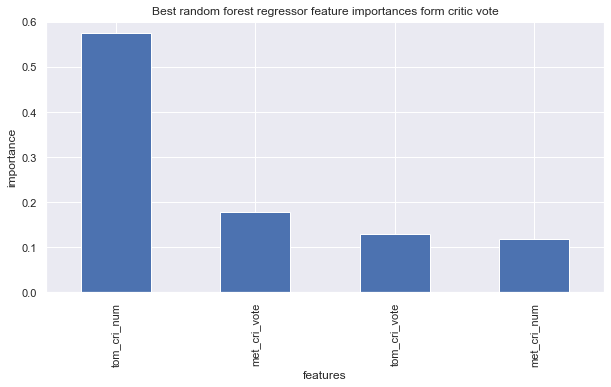

In [74]:
#find the importance of the features in the dataset
plt.subplots(figsize=(10, 5))
imps = rf_critic_model.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train_critic.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances form critic vote');

__Rotten Tomatto critic's number of vote__ appears to be the most importent features and has 60% perdiction power in this model. We can already assume that the box-office perdiction will be highly coorolates with this number.

In [52]:
#checking the mae result for this new model.
cv_results_critic = cross_validate(rf_critic_model.best_estimator_, X_train_critic, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [53]:
cv_results_critic['test_score']

array([-56795012.39140544, -67071735.80844904, -60029404.29113171,
       -62304704.11894775, -60945249.28724737])

In [54]:
np.mean(cv_results_critic['test_score'])

-61429221.17943625

In [55]:
y_pred_critic = rf_critic_model.best_estimator_.predict(X_test_critic)

In [56]:
mean_absolute_error(y_test,y_pred_critic)

78345049.64632103

In [57]:
explained_variance_score(y_test,y_pred_critic)

0.3555687680190446

Obviously the model performance decrese a lot and we have a larger margin of error as we already saw in pre-process step. Let's creates the same metrics as the original model and compare those 

In [59]:
result_critic = pd.DataFrame(y_test.values,y_pred_critic).reset_index() 
result_critic = pd.concat([result_critic,movie_class],axis=1).dropna()
result_critic

,index,0,class
0,1.467360e+06,1473445.0,Average
1,1.119725e+08,47275717.0,Average
2,7.174748e+06,7078.0,Average
3,2.924293e+07,4552970.0,Indie
4,8.878110e+07,13313581.0,Blockbuster
...,...,...,...
651,7.075386e+06,155215.0,Indie
652,2.705214e+06,507914.0,Average
653,1.412271e+06,61465.0,Indie
654,8.268102e+07,112983889.0,Indie


In [61]:
result_critic = result_critic.rename(columns={'index':'box-office',0:'prediction'})
result_critic['absolute_error'] = np.abs(result_critic['prediction'] - result_critic['box-office'])
result_critic['acuracy_of_perdiction'] =100 - ((result_critic['absolute_error']/result_critic['box-office']*100))
result_critic['prediction_error'] = (np.abs((result_critic['box-office']-result_critic['prediction']))/result_critic['box-office']) * 100

In [62]:
result_critic

,box-office,prediction,class,absolute_error,acuracy_of_perdiction,prediction_error
0,1.467360e+06,1473445.0,Average,6.084750e+03,99.585327,0.414673
1,1.119725e+08,47275717.0,Average,6.469681e+07,42.220817,57.779183
2,7.174748e+06,7078.0,Average,7.167670e+06,0.098652,99.901348
3,2.924293e+07,4552970.0,Indie,2.468996e+07,15.569474,84.430526
4,8.878110e+07,13313581.0,Blockbuster,7.546751e+07,14.995964,85.004036
...,...,...,...,...,...,...
651,7.075386e+06,155215.0,Indie,6.920171e+06,2.193732,97.806268
652,2.705214e+06,507914.0,Average,2.197300e+06,18.775373,81.224627
653,1.412271e+06,61465.0,Indie,1.350806e+06,4.352211,95.647789
654,8.268102e+07,112983889.0,Indie,3.030287e+07,63.349659,36.650341


In [63]:
result_critic.loc[result_critic.acuracy_of_perdiction<0,'acuracy_of_perdiction'] = 0

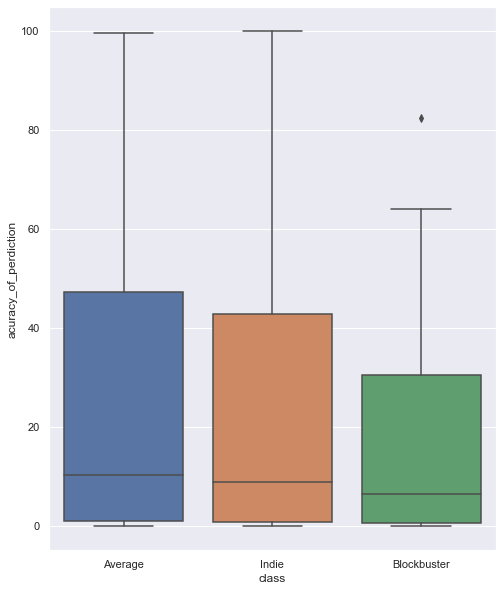

In [64]:
sns.set(rc={'figure.figsize':(8,10)})
_ = sns.boxplot(y='acuracy_of_perdiction',data=result_critic,x='class')

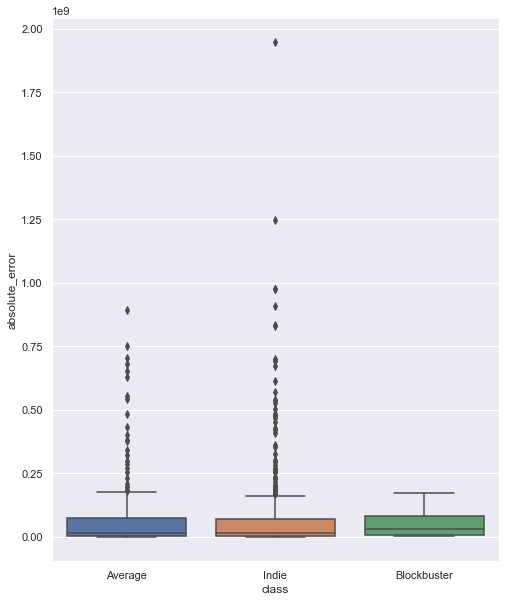

In [65]:
sns.set(rc={'figure.figsize':(8,10)})
_ = sns.boxplot(y='absolute_error',data=result_critic,x='class')

The mean acuracy for the test set drop to 20% (from the 35% of the original model) and mae also show a decrese but it is difinitly not as abvious as the acuracy drop.

Let's now check the perdiction for the 2021 movies that we used for the original model and see how critics early vote model can perdicts the box-office.

## Spider-Man : No Way Home (2021)
---


In [68]:
spider_critic = pd.DataFrame({     'tom_cri_vote':[93],
                                   'tom_cri_num':[385],
                                   'met_cri_vote':[71],
                                   'met_cri_num':[59]
                        
                            
                 })

In [69]:
spider_box_predict_critic = rf_critic_model.best_estimator_.predict(spider_critic.iloc[0].array.reshape(1, -1))

In [70]:
spider_box_predict_critic

array([5.45726251e+08])

__Spider-Man : No Way Home__

__Real Box-office : 1.7 Billion Dollars__


__Perdicted box office : 540 Million Dollars__


Although the model still perdict the class of the movie as a Blockbuster but the box-office perdiction has a larger error margine.

## Dune (2021):
---

In [71]:
dune_critic = pd.DataFrame({      'tom_cri_vote':[83],
                                  'tom_cri_num':[456],
                                  'met_cri_vote':[74],
                                  'met_cri_num':[67],
                            
                            
                 })

In [72]:
dune_box_predict_critic = rf_critic_model.best_estimator_.predict(dune_critic.iloc[0].array.reshape(1, -1))

In [73]:
dune_box_predict_critic

array([9.66674761e+08])

__Dune:__

__Real Box Office: 400 Million Dollars__

__Predicted Box Office: 966 Million Dollars__

Because critics love this film and vote more for it, we saw higher than what the film actually made in box-office. While the mae is still large but we still perdict the film class.

## House of Gucci (2021):
---

In [75]:
house_of_gucci_critic = pd.DataFrame({     'tom_cri_vote':[63],
                                    'tom_cri_num':[335],
                                    
                                    'met_cri_vote':[59],
                                    'met_cri_num':[57],

                 })

In [76]:
house_of_gucci_critic = rf_critic_model.best_estimator_.predict(house_of_gucci_critic.iloc[0].array.reshape(1, -1))

In [77]:
house_of_gucci_critic

array([4.25527951e+08])

__House of Gucci:__

__Real Box Office: 150 Million Dollars__

__Predicted Box Office: 425 Million Dollars__

Same effect happens for this film. Critics loved it more than audience therefore the critic model perdict bigger box-office for the film, still right class perdict for the film as and average film.

## Spencer (2021):
---

In [78]:
spencer_critic = pd.DataFrame({    'tom_cri_vote':[83],
                                   'tom_cri_num':[321],
                            'met_cri_vote':[76],
                            'met_cri_num':[53],
                            
                 })

In [79]:
spencer_critic = rf_critic_model.best_estimator_.predict(spencer_critic.iloc[0].array.reshape(1, -1))

In [80]:
spencer_critic

array([2.18386513e+08])

__Spencer:__

__Real Box Office: 20 Million Dollars__

__Predicted Box Office: 210 Million Dollars__


## Bergman Island (2021):
---

In [81]:
bergman_island_critic = pd.DataFrame({     'tom_cri_vote':[86],
                                    'tom_cri_num':[118],
                                    'met_cri_vote':[81],
                                    'met_cri_num':[26],
                                    
                 })

In [82]:
bergman_island_critic = rf_critic_model.best_estimator_.predict(bergman_island_critic.iloc[0].array.reshape(1, -1))

In [83]:
bergman_island_critic

array([4966480.37])

__Bergman Island:__

__Real Box Office: 700 Thousend Dollars__

__Predicted Box Office: 4 Million Dollars__


## The Last Execution (2021):

In [84]:
the_last_execution_critic = pd.DataFrame({     'tom_cri_vote':[10],
                                    'tom_cri_num':[2],
                                    'met_cri_vote':[0],
                                    'met_cri_num':[0],
                                   
                 })

In [85]:
the_last_execution_critic = rf_critic_model.best_estimator_.predict(the_last_execution_critic.iloc[0].array.reshape(1, -1))

In [86]:
the_last_execution_critic

array([271098.92])

__The Last Execution:__

__Real Box Office: 70 thousend Dollars__

__Predicted Box Office: 210 thousend Dollars__

## My Wonderful Wanda (2021):
---



In [88]:
my_wonderful_wanda_critic = pd.DataFrame({     'tom_cri_vote':[70],
                                               'tom_cri_num':[20],
                                               'met_cri_vote':[54],
                                               'met_cri_num':[8],
                                   
                 })

In [89]:
my_wonderful_wanda_critic = rf_critic_model.best_estimator_.predict(my_wonderful_wanda_critic.iloc[0].array.reshape(1, -1))

In [90]:
my_wonderful_wanda_critic

array([1273054.])

__My Wonderful Wanda:__

__Real Box Office: 200 thousend Dollars__

__Predicted Box Office: 1 Million Dollars__

## Between Two World (2021):
---

In [91]:
between_two_world_critic = pd.DataFrame({     'tom_cri_vote':[70],
                                               'tom_cri_num':[10],
                                               'met_cri_vote':[63],
                                               'met_cri_num':[6],
                                   
                 })

In [92]:
between_two_world_critic = rf_critic_model.best_estimator_.predict(between_two_world_critic.iloc[0].array.reshape(1, -1))

In [93]:
between_two_world_critic

array([31654093.93])

__Between Two World:__

__Real Box Office: 4 Million Dollars__

__Predicted Box Office: 31 Million Dollars__
